# Zenodo data
In this notebook, we explain the general structure of the [Zenodo dataset](https://zenodo.org/records/14407285). 

The dataset contains two types of files: 
- Posterior samples
- score model (= neural network) weights



## Posterior samples files
For posterior samples, all the files' name contain information about: 
- The disk whose surface brightness has been inferred,
- The score model used (either `veprobes`, `vpprobes` or `vpskirt`). 
- The sampler used for the inference (either `euler` or `pc`). For the PC sampler, the parameters used for sampling can be found in the "sampling_params" key of the .h5 file. 

The .h5 datasets also contains all the information needed to reproduce the results using the approach in the tutorial 2, including: 
- The observation (sampled visibilities),
- The noise estimate,
- The forward model parameters (sampling function, padding, primary beam, etc...).

Some disks were also used for additional testing of IRIS: 
- RU Lup was tested for the three different priors used in this work.
- Elias 24 was tested for the two different samplers, and for different sampling parameters with the PC sampler. 
- HD 143006 was tested for different scaling factors $s$. This factor is included in the filename for this disk (with the VP SKIRT prior). The scaling factor parameters for each protoplanetary disk can otherwise be found in the `dsharp_params.json` file. 

## Score model files
The weights of the score model files are compatible with the `score_models` package. We provide an example in tutorial 2 on how one can load the weights of the neural network using this package. 



## Visualization of the results
A basic analysis of the data can be performed with some of the functions from the `visualization.py` file. 
Let's first import the data from one of the protoplanetary disks. 

In [10]:
import os
import sys
sys.path.append("../src")
import wget
import torch 
import numpy as np 
import h5py
import json
import matplotlib.pyplot as plt
import scienceplots 
plt.style.use("science")
plt.rcParams['text.usetex'] = True
from visualization import * 

device = "cpu" # we don't need a GPU for this part of the code. 

disk = "HD143006_continuum"

# Getting the pixel size information from the dsharp_params.json file. 
with open("../dsharp_params.json", 'r') as file:
    dict_disks_info = json.load(file) 
disk_info = dict_disks_info[disk]
pixel_scale = disk_info['pixel_scale'] # pixel size in image space (arcsec)

data_folder = "data" 
os.makedirs(data_folder, exist_ok=True)
fname = os.path.join(data_folder, f"{disk}_veprobes_euler.h5")
if not os.path.exists(fname): 
    url = f"https://zenodo.org/records/14407285/files/{disk}_veprobes_euler.h5?download=1"
    wget.download(url, data_folder)

with h5py.File(fname, "r") as hdf:
    vis = torch.tensor(hdf["vis"][:], device = device, dtype = torch.float32) # Jy/pixel
    vis_noise = torch.tensor(hdf["vis_noise"][:], device = device, dtype = torch.float32) # Jy/pixel (standard deviation of a Gaussian)
    samples = torch.tensor(hdf["posterior_samples"], device = device, dtype = torch.float32) # Jy/pixel 
    S = torch.tensor(hdf["sampling_function"][:], device = device, dtype = torch.bool)
    B = hdf["B"][()]
    pad = tuple(hdf["pad"][:])
    pb = torch.tensor(hdf["primary_beam"][:], device = device, dtype = torch.float32 )
    hdf.close()

npix = S.shape[0]
img_size = 256
num_samples = len(samples)

We can plot a number of posterior samples using the `plot_grid_samples(*args)` function. 

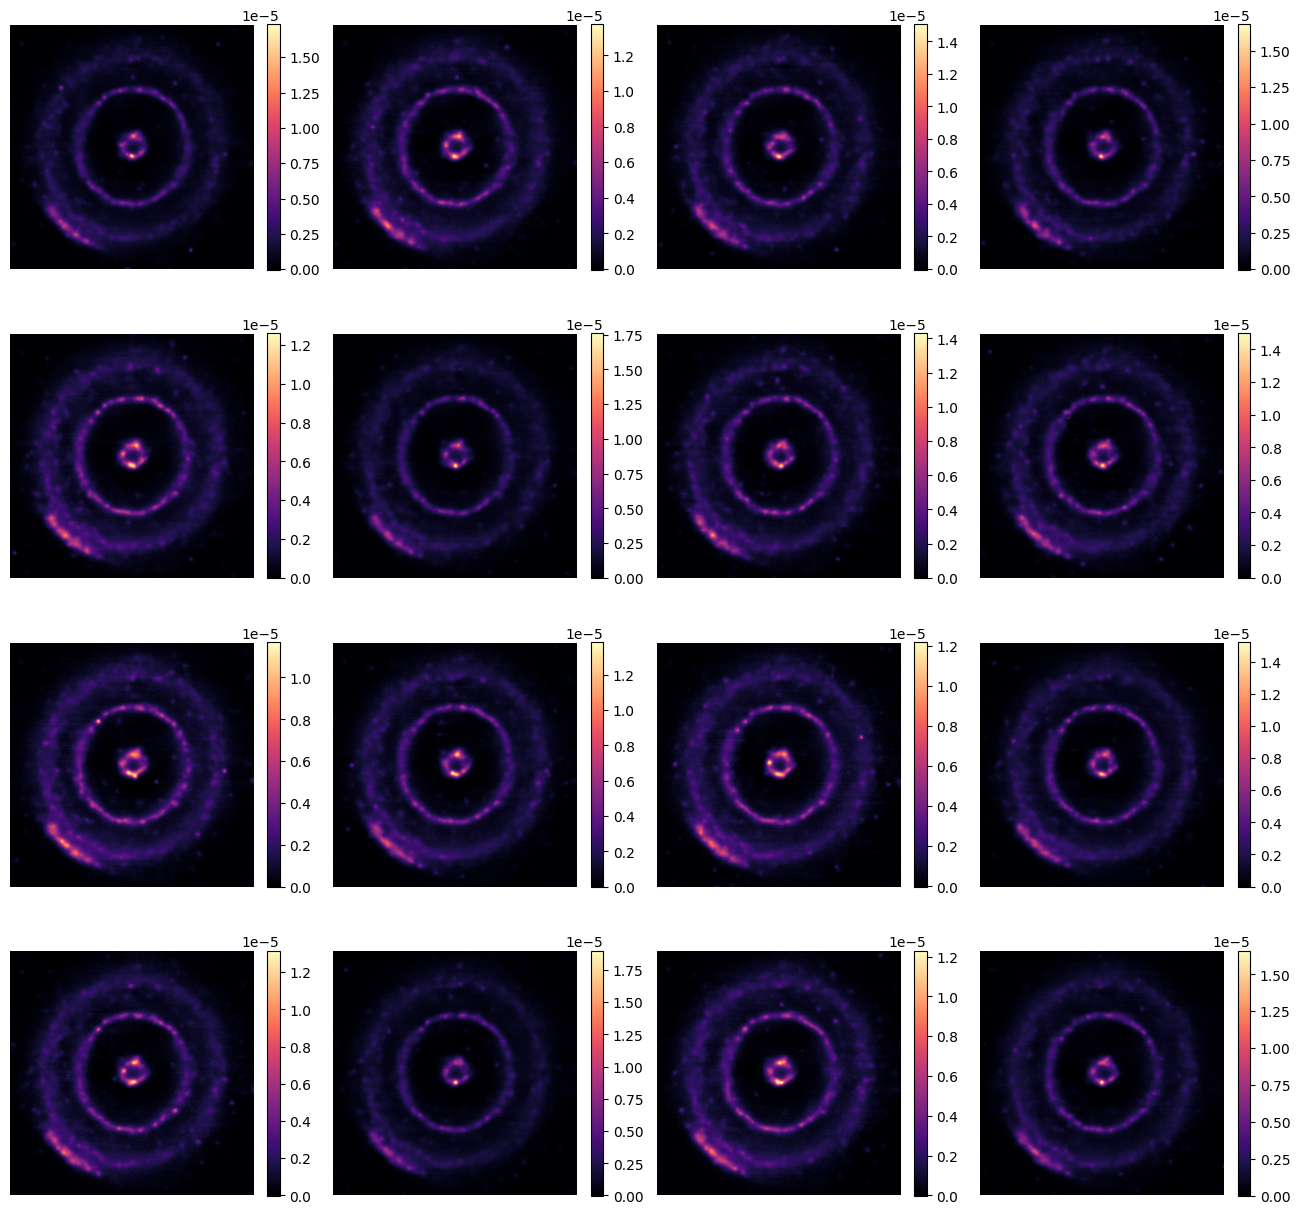

In [2]:
from matplotlib.colors import LogNorm 
plot_grid_samples(samples, N=4, wspace = 0.2, hspace=0.01) # units are Jy/pixel

We can also compute some of the statistics using the `plot_stat(*args)` function. We will need the residuals for this. I show below how to compute the model prediction and how to compute the residuals for one posterior sample (the operation can be iterated over for all the posterior samples in the dataset).

In [3]:
from inference.forward_model import model
from tqdm import tqdm 

model_params = (S, torch.ones(size = (npix, npix), device = device), B, 0, pad, "zero")
vis_pred = model(None, samples[42] / B  *  pb, None, model_params)


residuals = (vis - vis_pred) / vis_noise
residuals_grid = np.empty(shape = (npix, npix), dtype = np.complex64)
m = len(vis) // 2
residuals_grid[S] = residuals[:m] +  1j * residuals[m:]

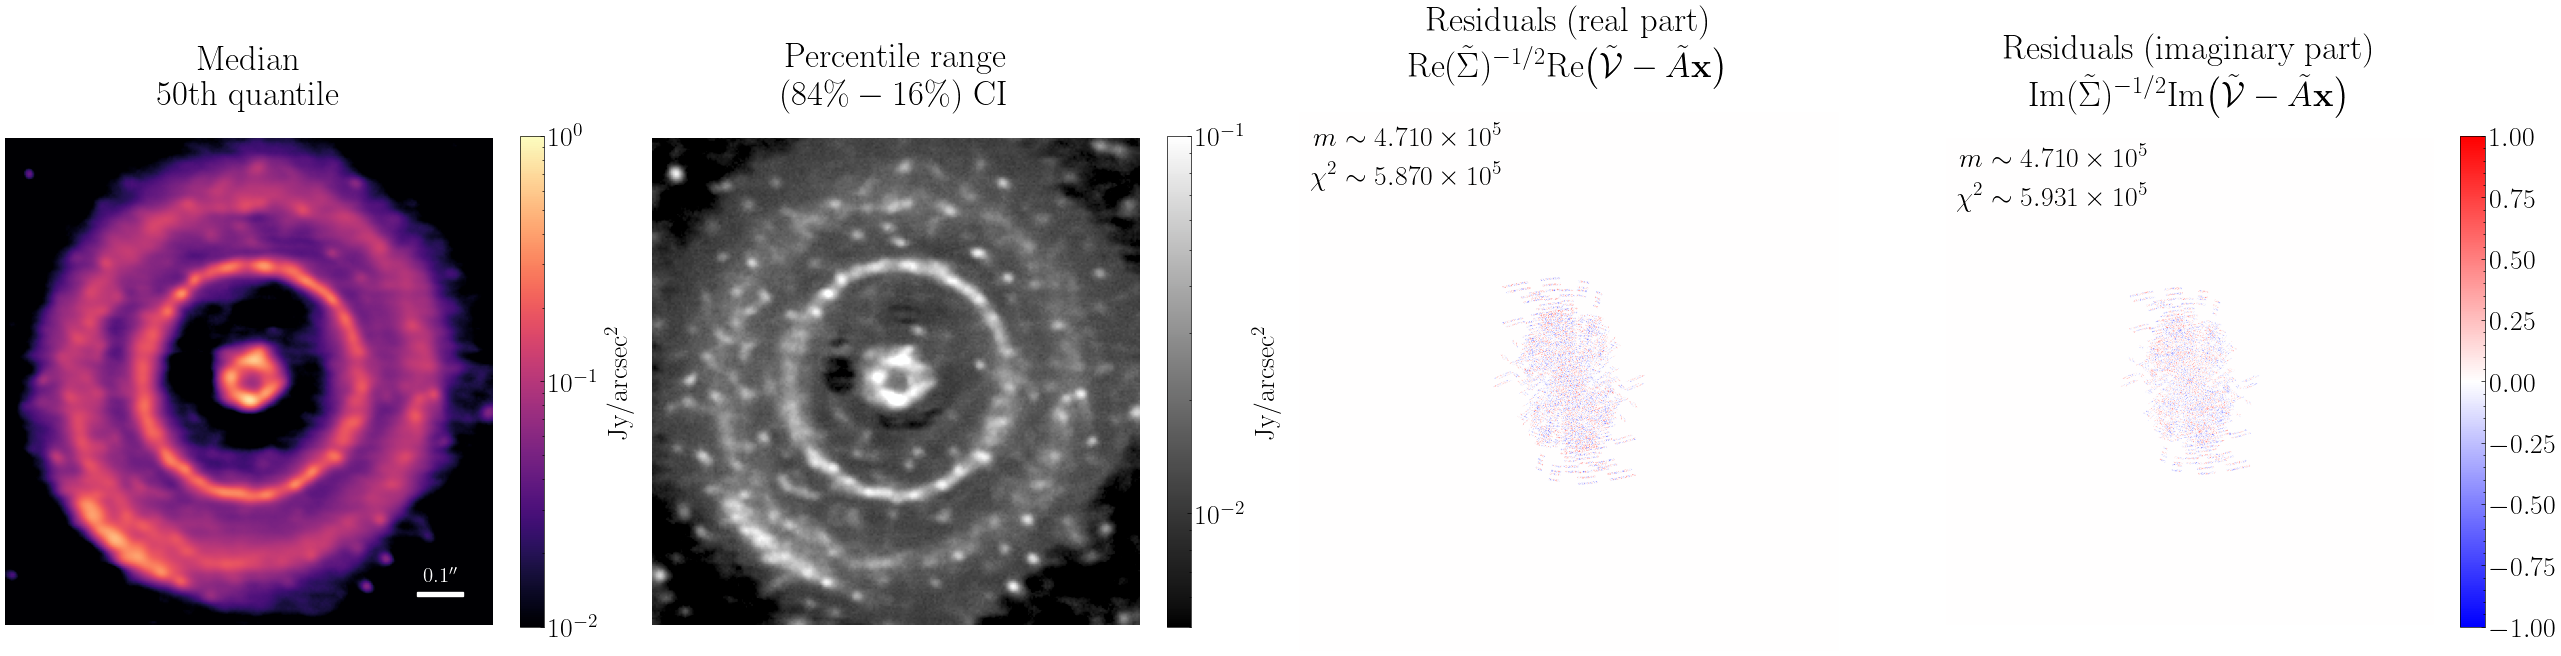

In [29]:
import colorcet as cc
median = compute_median(samples).squeeze() # Jy / pixel
pr = compute_percentile_range(samples).squeeze() # Jy / pixel

fig, axs = plt.subplots(1, 4, figsize = (8 * 4, 8 * 1))
imgs = plot_stats(
    axs, 
    median = median / pixel_scale ** 2, # Jy/arcsec^2
    pr = pr / pixel_scale ** 2, # # Jy/arcsec^2
    pixel_scale = pixel_scale,
    residuals = residuals_grid, 
    show_chi2 = True,
    show_title = True,
    show_pixel_scale = True,
    med_params = ("magma", LogNorm(vmin = 1e-2, vmax = 1e0, clip = True)), # to change colors/normalization
    pr_params = (cc.cm["gray"], LogNorm(vmin = 5e-3, vmax = 1e-1, clip = True)), 
    show_text = True,
    fontsize = 20
)

for i, im in enumerate(imgs): 
    cbar = plt.colorbar(im, fraction = 0.0455)
    cbar.ax.tick_params(labelsize=20)
    if i==0 or i==1:
        cbar.set_label(r"Jy/arcsec$^2$", fontsize = 20)

With this you should be able to get started if you need this data for your research. 